## Семинар 6 "Segmentation"

ФИО: __Иванов Иван Иванович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet50
import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from IPython.display import clear_output
from PIL import Image
import skimage
from skimage import io
from torchvision import models
import torch
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.nn import CrossEntropyLoss, Sequential, Linear, Sigmoid, Tanh, BCELoss, Softmax, BatchNorm1d
from torch.utils.data.sampler import Sampler, SubsetRandomSampler, WeightedRandomSampler
from PIL import Image # Replace by accimage when ready
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90, ROTATE_180, ROTATE_270
from PIL.ImageEnhance import Color, Contrast, Brightness, Sharpness
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import imageio

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

C:\Users\vkrin\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
train_dataloader = t.utils.data.DataLoader(dataset,batch_size=4)
control_dataloader = t.utils.data.DataLoader(dataset, batch_size=4,shuffle=True)

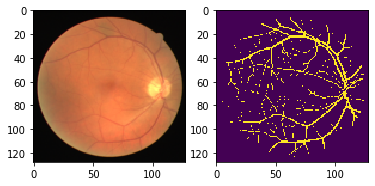

In [4]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [5]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [65]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [137]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal(layer.weight)
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (4,4), padding=(2,2)), nn.ReLU(),
                                        nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (4,4), padding=(2,2)), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                        nn.Conv2d(16, 32, (4,4), padding=(2,2)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, (4,4), padding=1),nn.ReLU(),
                                        nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(64*49, 400),
                                           nn.BatchNorm1d(400),
                                           nn.ReLU(),nn.Linear(400, 200),nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                          nn.Linear(200, 128*128))
        self.linear_layers.apply(init_weights)
        

    def forward(self, x):
        #print(x.shape)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #print(x.shape)
        return x

In [138]:
model =ConvClassifier(image_size=128)

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [213]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=4)

In [140]:
dtype=torch.FloatTensor
def train(network, epochs, learning_rate):
    loss = soft_dice_loss
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_dataloader:
                #print(X.shape, y.shape)
                y = y.view(y.shape[0], -1).type(dtype)
               # print(X.shape, y.shape)
                network.zero_grad()
                prediction = network(X)
               # print(prediction.shape)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            losses = [] 
            for X, y in control_dataloader:
                y = y.view(y.shape[0], -1).type(dtype)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
            test_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
        plt.figure(figsize=(12, 5))
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    except KeyboardInterrupt:
        pass

Epoch 99... (Train/Test) NLL: 0.820/0.825


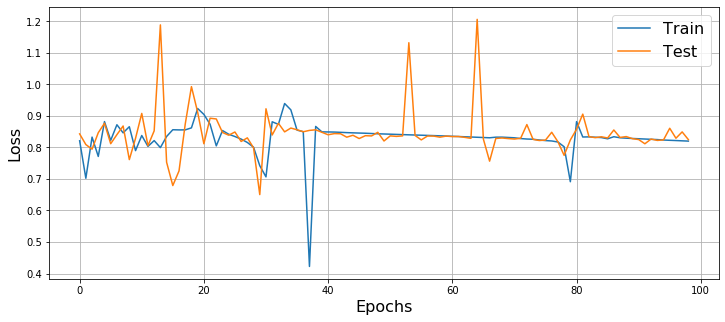

In [141]:
train(model, 100, 1e-2)

In [153]:
def show(image, mask):
    """Show image with landmarks"""
    print(image.shape)
    plt.imshow(image)
    plt.imshow(mask)
    plt.pause(0.001)  

torch.Size([1, 128, 128])


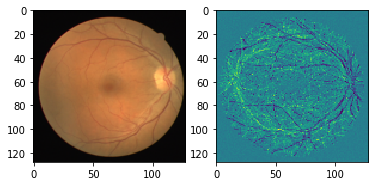

In [211]:
test_dataloader = t.utils.data.DataLoader(dataset, batch_size=2,shuffle=True)
batch = next(iter(test_dataloader))
images_batch = batch[0][0]
#print(images_batch.shape)
y_pred = model(batch[0])
y_pred = y_pred.view(2,1,128,128)[0]
print(y_pred.shape)
plt.subplot(121)
plt.imshow(images_batch.permute(1,2,0).numpy()*0.5+0.5)
#plt.subplot(132)
#plt.imshow(batch[1][0][0].numpy())
plt.subplot(122)
plt.imshow(y_pred[0].data.numpy())

In [ ]:
for 

In [207]:
y_pred

tensor([[[4.2453, 4.3808, 4.4251,  ..., 4.4282, 4.2532, 4.3539],
         [4.4477, 4.0684, 4.4137,  ..., 4.2350, 4.1049, 4.2683],
         [4.4368, 4.3873, 4.2516,  ..., 4.3467, 4.3845, 4.2958],
         ...,
         [4.2569, 4.2143, 4.2819,  ..., 4.3463, 4.2094, 4.2245],
         [4.4696, 4.3480, 4.3099,  ..., 4.4258, 4.3608, 4.3492],
         [4.2419, 4.2360, 4.3305,  ..., 4.2588, 4.2926, 4.4857]]],
       grad_fn=<SelectBackward>)

In [220]:
os.makedirs("result")
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [225]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Max value == min value, ambiguous given dtype

In [16]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

NameError: name 'o' is not defined